In [176]:
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Analyzing Emotional Arcs in Paths

This notebook aims to analyze emotional arcs in a dataset of paths. Each path consists of a series of sentiment scores representing emotional states over a Wikispeedia path. We categorize each path into one of five categories: positive to negative, negative to positive, positive to positive, negative to negative and mixed emotions.


In [177]:
def analyze_emotional_arcs(data, threshold=0):
    """
    Analyze emotional arcs in the given dataset with a threshold to determine sentiment.
    
    Parameters:
    data (list of lists): Each sublist represents a path with sentiment scores.
    threshold (float): The value used to determine the sentiment threshold.
    
    Returns:
    dict: A dictionary with analysis results, including common patterns in emotional arcs.
    """
    analysis_results = {
        'positive_to_negative': 0,
        'negative_to_positive': 0,
        'positive_to_positive': 0,
        'negative_to_negative': 0,
        'mixed_emotions': 0
    }
    
    for path in data:
        if len(path) < 3:
            analysis_results['mixed_emotions'] += 1
            continue

        third = len(path) // 3
        start_third_avg = sum(path[:third]) / third
        middle_third_avg = sum(path[third:-third]) / (len(path) - 2 * third) if len(path) - 2 * third > 0 else 0
        end_third_avg = sum(path[-third:]) / third
        
        if start_third_avg > threshold and end_third_avg < -threshold:
            analysis_results['positive_to_negative'] += 1
        elif start_third_avg < -threshold and end_third_avg > threshold:
            analysis_results['negative_to_positive'] += 1     
        elif start_third_avg > threshold and middle_third_avg < -threshold and end_third_avg > threshold:
            analysis_results['positive_to_positive'] += 1
        elif start_third_avg < -threshold and middle_third_avg > threshold and end_third_avg < -threshold:
            analysis_results['negative_to_negative'] += 1
        else:
            analysis_results['mixed_emotions'] += 1

    return analysis_results


After defining the function, all the necessary data have to be imported in the notebook.

In [178]:
with open('df_paths_direct.pickle', 'rb') as file:
    df_paths = pickle.load(file)

df_paths.head()

,Scores,Rounded,Target score
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN


Upon defining the function and importing the patterns, the initial step in our analysis should involve quantifying the diversity of prevalent trends observed.

In [189]:
emotional_arcs_analysis = analyze_emotional_arcs(df_paths['Scores'], threshold=0.25)
total_paths = sum(emotional_arcs_analysis.values())
emotional_arcs_proportions = {arc: count / total_paths for arc, count in emotional_arcs_analysis.items()}
for arc, proportion in emotional_arcs_proportions.items():
    print(f"{arc}: {proportion*100:.4f}%")

positive_to_negative: 0.3545%
negative_to_positive: 0.4425%
positive_to_positive: 0.0053%
negative_to_negative: 0.0053%
mixed_emotions: 99.1925%


- The vast majority of paths exhibit mixed emotions, indicating a complex emotional journey rather than an easily identifiable path.
- A small number of paths show a transition from positive to negative emotions. Furhter analysis are needed to infer the relvance of these paths.
- U-shaped emotional arcs, oscillating from positive to negative back to positive (and vice versa), are exceedingly uncommon and can likely be disregarded.


In [224]:
def split_list(lst):
    """Split a list into sublists."""
    n = len(lst)
    size = n // 3
    remainder = n % 3
    indices = [0 + size * i + min(i, remainder) for i in range(4)]
    return [lst[indices[i]:indices[i + 1]] for i in range(3)]

# Divide the paths into three parts and remove the ones with length inferior to 3
df_paths['Split_Scores'] = df_paths['Scores'].apply(lambda x: split_list(x) if len(x) >= 3 else np.NaN)
data = df_paths['Split_Scores'].dropna().to_list()

To streamline the analysis of the patterns, it's advantageous to categorize them into three distinct and easily identifiable values, that is, the beginning, the middle and the end of the paths. This categorization simplifies the means to perform further comparison and enhances the interpretability of results.

In [192]:
mean_list = []
for sublist in data:
    new_list = []
    for list in sublist:
        mean = np.mean(list)
        new_list.append(mean)
    mean_list.append(new_list)

[[-0.05701372331580512, 0.02285048508252055, -0.5790338682112557], [-0.09784516017212513, -0.4750232424984818, -0.7870551196368035], [-0.3156218438435746, -0.35942066050603594, -0.818829315600258], [-0.05487595883307892, -0.05476150467499277, 0.0806443166846585], [-0.05895270712643638, -0.49519910992416655, -0.03754376001933862], [-0.09784516017212513, -0.0016815061165783643, -0.03754376001933862], [-0.09240827325853487, -0.13742380345616906, -0.7144366225144638], [-0.10061883050729628, -0.012828907013840526, -0.03741367067654215], [-0.10061883050729628, 0.010673633572270663, 0.0501497921432464], [-0.08169818153435701, -0.0722159117592945, -0.03741367067654215]]


To enhance our comprehension of the prevalent trends in Wikispeedia patterns, performing clustering can be a good idea. This technique excels in neatly segmenting complex data into distinct groups based on similarities, thereby spotlighting the most common behavioral patterns.

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kme

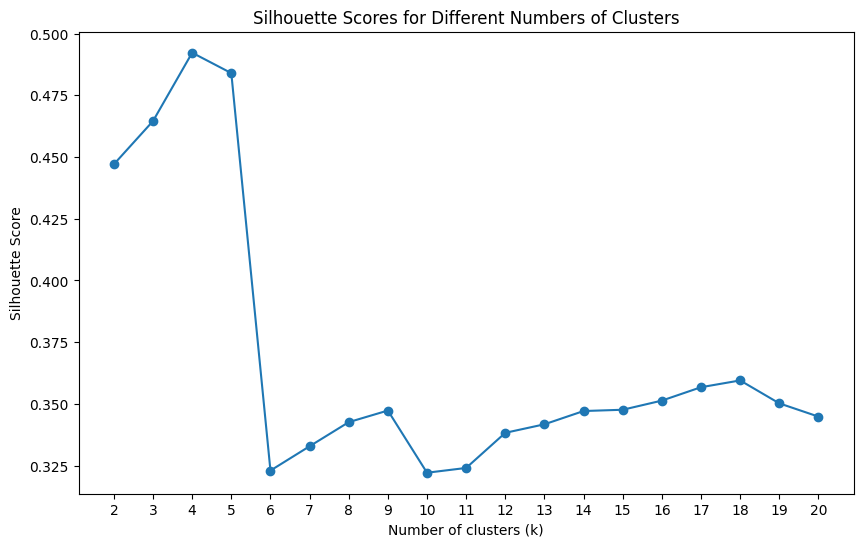

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [193]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

features = np.array([[lst[i+1] - lst[i] for i in range(len(lst)-1)] for lst in mean_list])

k_range = range(2, 21) 

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(features)
    
    score = silhouette_score(features, clusters)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xticks(k_range)
plt.show()

scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

k = silhouette_scores.index(max(silhouette_scores)) + 2
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(features_normalized)


The silhouette score analysis of the data conclusively indicates that four clusters are sufficient to encapsulate the key variations in path trends, providing a clear and efficient segmentation for understanding the essential differences.

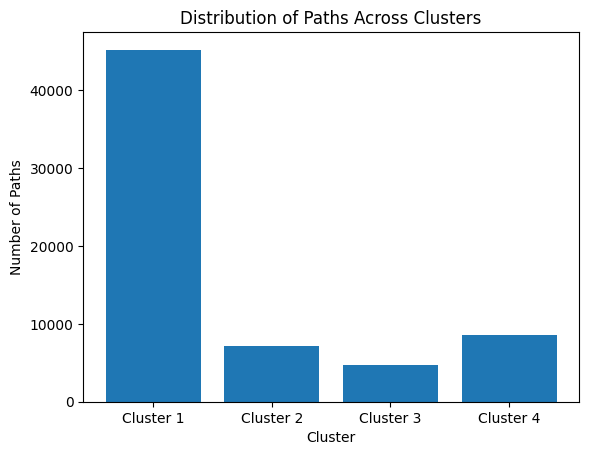

In [223]:
frequencies = []
for i in range(k):
    count = 0
    for j, lst in enumerate(data):
        if clusters[j] == i:
            count += 1
    frequencies.append(count)

cluster_labels = [f'Cluster {i+1}' for i in range(k)]
plt.bar(cluster_labels, frequencies)
plt.xlabel('Cluster')
plt.ylabel('Number of Paths')
plt.title('Distribution of Paths Across Clusters')
plt.show()
            

In the first cluster, the vast majority of the paths are grouped, indicating that this cluster represents the most dominant pattern in the dataset. The second and fourth clusters contain a considerable but notably smaller number of paths compared to the first, suggesting that while these patterns are significant, they are less prevalent, while the third cluster shows to contain the fewest paths.

In [202]:
mean_clusters = []
for i in range(k):
    new_list = []
    for j, lst in enumerate(data):
        if clusters[j] == i:
            new_list.append([sum(sublist) / len(sublist) for sublist in lst])
    cluster_mean = [sum(values) / len(new_list) for values in zip(*new_list)]
    mean_clusters.append(cluster_mean)
mean_clusters


[[-0.017705864123951028, -0.03170449012798683, -0.031857737529575186],
 [0.03360141880368962, -0.38773065298533993, 0.000854962058018365],
 [-0.028907001768949975, -0.053004202648305, -0.6558251193189248],
 [-0.34800231874036347, 0.08794727616881073, 0.009428076092706076]]

In order to effectively visualize and understand the trends represented by these clusters, a graphical representation is indeed more suited.

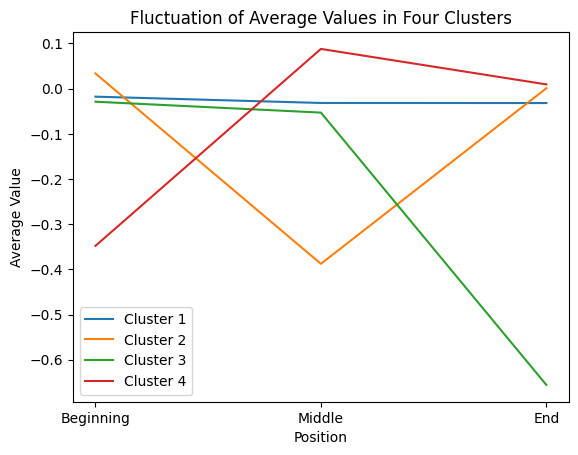

In [212]:
for i, cluster in enumerate(mean_clusters):
    plt.plot(['Beginning', 'Middle', 'End'], cluster, label=f'Cluster {i+1}')

plt.xlabel('Position')
plt.ylabel('Average Value')
plt.title('Fluctuation of Average Values in Four Clusters')
plt.legend()
plt.show()

This plot illustrates the predominant trends identified in our pattern analysis. The first cluster, representing the most common trend, follows a consistent trajectory with a near-zero value, aligning with our expectations of a stable, neutral sentiment. The second trend showcases a U-shaped pattern, beginning and ending with neutral sentiment but dipping into negative territory in the middle. This suggests a tendency for neutral articles to briefly adopt a more negative tone before returning to neutrality. The third and fourth clusters, though less common, exhibit distinct characteristics: the third starts negatively before transitioning to neutrality, while the fourth does the opposite, ending on a negative note after a neutral start.

The noticeable absence of positive sentiment peaks across all clusters lends credence to an earlier observation in our analysis: the algorithm employed for sentiment analysis tends to identify more negative sentiments. This bias towards negativity could likely be attributed to the structural and stylistic elements of Wikipedia articles. Such articles, often factual and objective in nature, may inherently contain language that the algorithm interprets more easily as negative rather than positive. 